# Abundance ratios with different stellar yield sets

The yields from stellar nucleosynthesis models form an integral part of any GCE code. However, the yields calculated by different stellar evolution groups are not always consistent, to the extent that the uncertainties associated with stellar nucleosynthesis dominate the total GCE uncertainty for some elements (see, e.g. Côté et al. 2017). It is therefore essential that GCE predictions are calculated using yield sets from different stellar evolution codes, so that the conclusions drawn are robust for different choices of the input physics

In this notebook we first compare the [Fe/H] and metallicity evolution for different yield tables, in particular we explore how these quantities change when the initial mass function (IMF) and number of SNe Ia are treated as free parameters. Following this, we compare the predicted evolution of certain elemental abundance ratios in the Galaxy to spectroscopic measurements from stars. 

In [1]:
# Import python modules
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Import the OMEGA+ module
from JINAPyCEE import omega_plus
from NuPyCEE import stellab

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from matplotlib.ticker import AutoMinorLocator, MultipleLocator

# Run scripts for this notebook
%run script_solar_ab.py

# Matplotlib option
%matplotlib inline

/var/folders/13/_3g2lmwx6xl3zshjv1d7yz4c0000gn/T/ipykernel_45091/1779573496.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Function used to find the timestep where Z is nearest to Z_solar 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [3]:
# run a default OMEGA+ instance to extract default parameter choices
op=omega_plus.omega_plus()

# Initialize stellar abundance data from stellab
s=stellab.stellab()

OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 0.44s
   OMEGA+ run completed - Run time: 0.81s


## Default stellar yield parameters used by OMEGA 

The stellar yield table contains yields for low- and intermediate-mass stars (LIMS; $M_{\star}<8M_{\odot}$) and massive stars $(M_{\star}>8M_{\odot}$). The transition mass tentatively delimitates between intermediate-mass stars and massive stars, and its value throughout this workshop is fixed at $M_{\text{trans}}=8 M_{\odot}$.

Stars with initial masses in the range defined by the IMF are assumed to contribute to GCE - stars with masses above or below this threshold are not included in the chemical evolution process.

The number of SNe Ia that form per stellar mass is defined by the nb_1a_per_m paramter. 

In [4]:
print('AGB + massive star yields:', op.inner.table.split('/')[1])

print('IMF range considered:', op.inner.imf_yields_range)

print('SNe Ia per stellar mass:', op.inner.nb_1a_per_m)

AGB + massive star yields: agb_and_massive_stars_nugrid_MESAonly_fryer12delay.txt
IMF range considered: [1, 30]
SNe Ia per stellar mass: 0.001


## Exploration of different yield sets

From above, we can see that the default yields used by OMEGA contain the LIMS from the NuGrid collaboration and the massive star yields from Fryer et al. 2012. In the cell below, we run three instances of OMEGA+ using different choices of the LIMS and massive star yields. The upper mass limit for the IMF (default value 30) and the nb_1a_per_m (default value 0.001) can be modified.

In [44]:
# make dictionary
op_dict={}

# first infall parameters
N_1 = 55
t_01 = 0
tau_1 = 0.2e9

# second infall parameters
N_2 = 8
t_02 = 4.0e9
tau_2 = 5e9

# Build the infall array
exp_2infall = [[N_1,t_01,tau_1], [N_2,t_02,tau_2]]

# controlling the magnitude of galactic outflows
mass_loading = 1.0

# star formation efficiency
sfe = 0.02

# Yield tables
tables = ['yield_tables/agb_and_massive_stars_C15_LC18_R_mix.txt',
          'yield_tables/agb_and_massive_stars_K10_K06_0.0HNe.txt',
          'yield_tables/agb_and_massive_stars_nugrid_FRUITY.txt']

#############################################################################
############### \\\\\\\\\\\\\\\ MODIFY BELOW //////////////// ###############
#############################################################################

# IMF yields range
imf_yields_upper = 100

# transition mass
nb_1a_per_m=0.001

#############################################################################
#############################################################################

# build IMF array
imf_yields_range = [0,imf_yields_upper]

for table in tables:
    op_sfe = omega_plus.omega_plus(special_timesteps=150, 
                                   exp_infall=exp_2infall,
                                   sfe=sfe,
                                   mass_loading=mass_loading,
                                   table=table,
                                   nb_1a_per_m=nb_1a_per_m,
                                   imf_yields_range=imf_yields_range,
                                    )

    op_dict[str(table.split('stars_')[1].split('.txt')[0])+', nb_1a='+str(nb_1a_per_m)+', IMF_up:'+str(imf_yields_upper)]=op_sfe

OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 1.93s
   OMEGA+ run completed - Run time: 2.73s
OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 1.89s
   OMEGA+ run completed - Run time: 2.27s
OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 1.9s
   OMEGA+ run completed - Run time: 2.24s


## [Fe/H] and global metallicity evolution of the GCE models  

The evolution of [Fe/H] and Z versus Galactic age for the three OMEGA+ models are shown in the Figures below.

### Questions
- Which combination of upper mass limit for the IMF and SNe Ia number can best reproduce the solar [Fe/H] and Z at $t_{\odot}$ for each yield set?
- Is the IMF mass range or the SNe Ia number more impactful for [Fe/H] and Z?

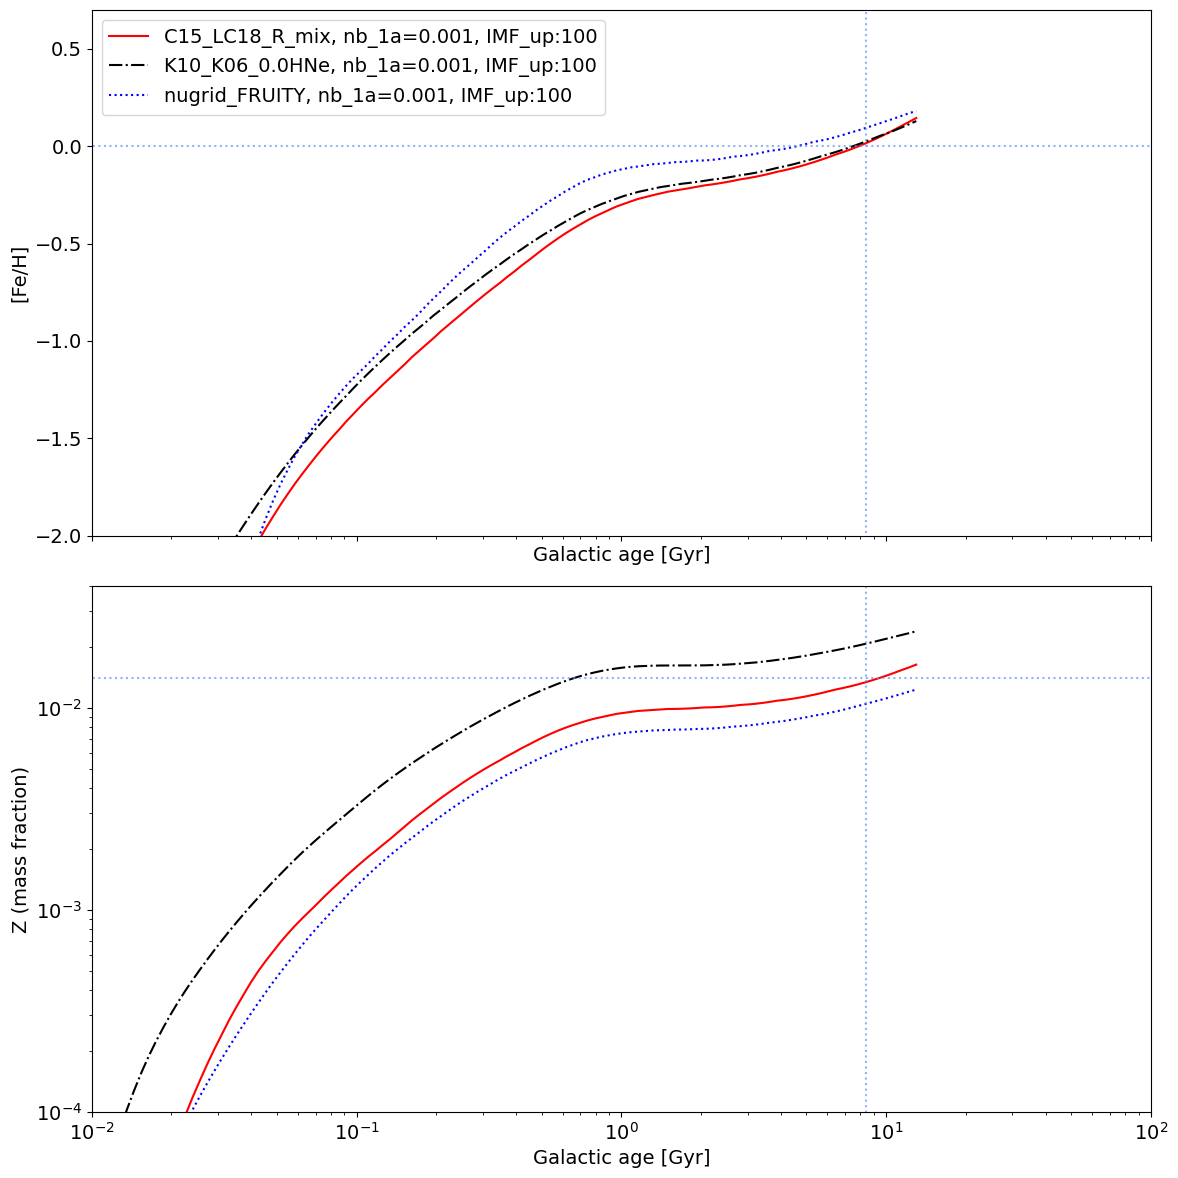

In [45]:
plt.close()
# Figure frame
%matplotlib inline
al_f = 14 # text font
matplotlib.rcParams.update({'font.size': 14.})
f, axarr = plt.subplots(2, 1, figsize=(12,12), sharex=True, sharey=False) # [row][col]
f.subplots_adjust(hspace=0.)
f.subplots_adjust(wspace=0.5)
colors = ['r','k','b','green','cyan','magenta'
         ]*5

linestyles = ['-','-.',':','-','-.',
             ]*6

labels = []

# X-axis
axarr[1].set_xlim(1e-2,1e2)



def plot_spectr(omega_run, solar_norm):
    return(omega_run.inner.plot_spectro(solar_norm=solar_norm, return_x_y=True))

time=[]
Fe=[]
# Extract predictions
for key, val in op_dict.items():
    time.append(plot_spectr(val, 'Lodders_et_al_2009')[0])
    Fe.append(plot_spectr(val, 'Lodders_et_al_2009')[1])

# Plot age-[Fe/H]
# ===============
i=0
for key, val in op_dict.items():
    axarr[0].plot(np.array(time[i])/1e9, Fe[i], colors[i], ls=linestyles[i], linewidth=1.5, label=key)
    i+=1

axarr[0].plot([(13-4.6),(13-4.6)], [-10, 10], ':', color='cornflowerblue', alpha=0.7)
axarr[0].plot([-1e10,1e10], [0,0], ':', color='cornflowerblue', alpha=0.7)
axarr[0].set_ylim(-2., 0.7)

i=0
for key, val in op_dict.items():
    axarr[1].plot(np.array(val.inner.history.age)/1e9, val.inner.history.metallicity, colors[i], ls=linestyles[i],linewidth=1.5)
    i+=1
           
axarr[1].plot([(13-4.6),(13-4.6)], [-10, 10], ':', color='cornflowerblue', alpha=0.7)
axarr[1].plot([-1e10,1e10], [0.014,0.014], ':', color='cornflowerblue', alpha=0.7)
axarr[1].set_yscale('log')
axarr[1].set_xscale('log')
axarr[1].set_ylim(1e-4, 4e-2)

# Labels and visual aspect
axarr[0].set_ylabel('[Fe/H]', fontsize=al_f)
axarr[1].set_ylabel('Z (mass fraction)', fontsize=al_f)
axarr[1].set_xlabel('Galactic age [Gyr]', fontsize=al_f)
axarr[0].set_xlabel('Galactic age [Gyr]', fontsize=al_f)
axarr[0].legend()
plt.tight_layout()

## Comapring GCE tracks to stellab abundance data

In the four panels of the Figure below, the evolution of oxygen, aluminium, nickel, and zinc are compared for the GCE tracks of the three OMEGA+ runs. Spectroscopic abundance data from four different observational papers are also shown. Feel free to modify the list of elements to plot (only 4 can be plotted at a time with this script).

### Questions
- Without any prior knowledge of the delay times of different enrichment events, how could you tell that low-mass stars and SNe Ia start to contribute at later times to the Galactic enrichment process compared to massive stars?  

!! Warning - stellab_data/milky_way_data/Hinkel_et_al_2014_stellab not available !!
!! Warning - stellab_data/milky_way_data/Hinkel_et_al_2014_stellab not available !!
!! Warning - stellab_data/milky_way_data/Hinkel_et_al_2014_stellab not available !!
!! Warning - stellab_data/milky_way_data/Hinkel_et_al_2014_stellab not available !!


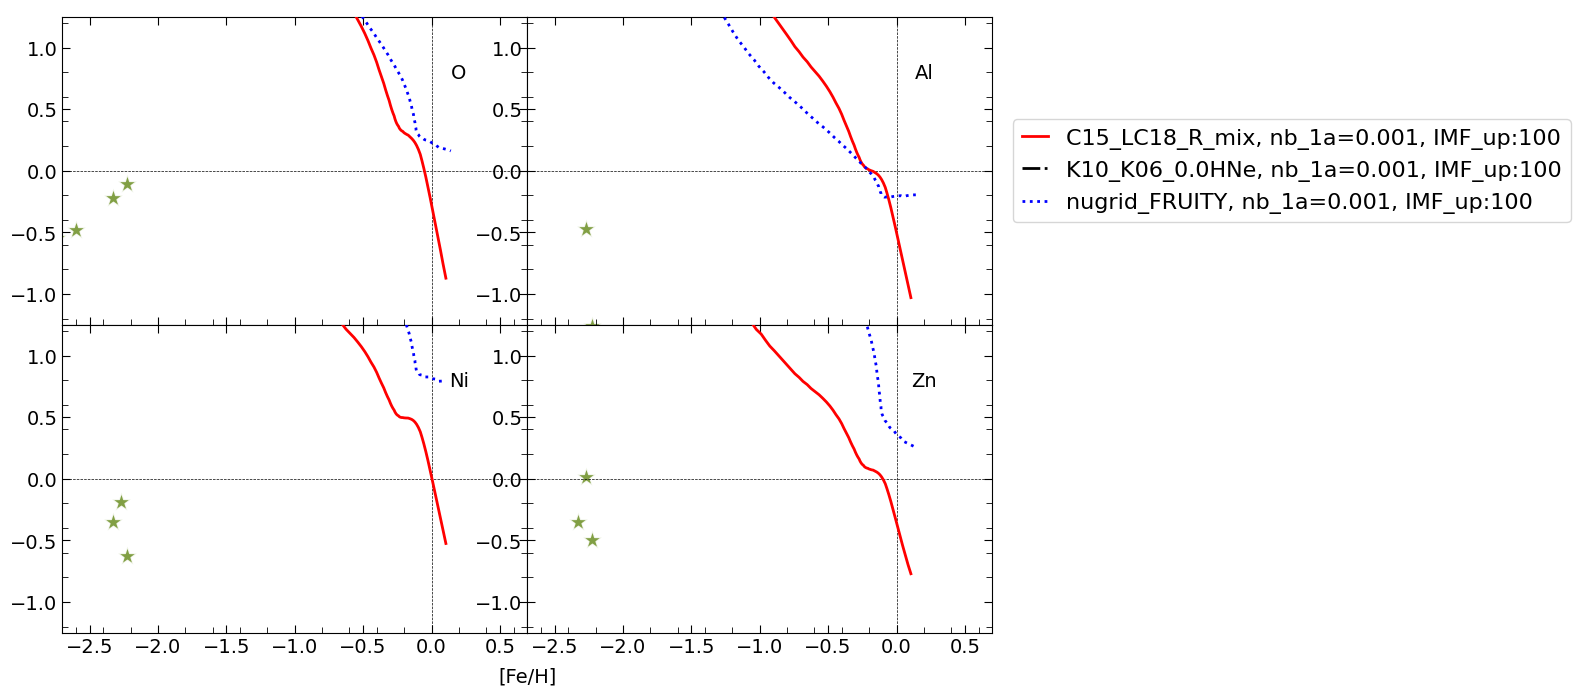

In [67]:
plt.close()
# Figure frame
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14.})
f, axarr = plt.subplots(2, 2, figsize=(12,8)) # [row][col]
f.subplots_adjust(hspace=0.)
f.subplots_adjust(wspace=0.) 

# make a dictionary of abundance ratios to be plotted
axis_dict={}

#############################################################################
############### \\\\\\\\\\\\\\\ MODIFY BELOW //////////////// ###############
#############################################################################

# elements to plot 
ele_list = ['O', 'Al', 'Ni', 'Zn']

#############################################################################
#############################################################################

count=0
for ele in ele_list:
    axis_dict['['+ele+'/Ag]']='[Fe/H]'
    count+=1
    if count == 4:
        break


j=0
l=0
chi_LC18_sub={}
for yaxis, xaxis in axis_dict.items():
    chi_LC18_sub[yaxis]={}
    
#     list of observational data in figure
    obs=[
     'stellab_data/milky_way_data/Adibekyan_et_al_2012_stellab', 
        'stellab_data/milky_way_data/Reddy_et_al_2003_stellab',
         'stellab_data/milky_way_data/Reddy_et_al_2006_stellab',
             "stellab_data/milky_way_data/Bensby_et_al_2014_stellab",
         "stellab_data/milky_way_data/Cohen_et_al_2013_noCEMPs_stellab", 
             "stellab_data/milky_way_data/Frebel_2010_Milky_Way_stellab", 
             "stellab_data/milky_way_data/Gratton_et_al_2003_stellab",
         "stellab_data/milky_way_data/Hinkel_et_al_2014_stellab",
        'stellab_data/milky_way_data/Ishigaki_et_al_2012_2013_stellab',
             "stellab_data/milky_way_data/Jacobson_et_al_2015_stellab",
         "stellab_data/milky_way_data/Roederer_et_al_2014_pecu_excluded_stellab",
             'stellab_data/milky_way_data/Yong_et_al_2013_stellab',
     ]
    x=[]
    y=[]
    data_col=['cadetblue','darkkhaki','darkkhaki','plum','grey','olivedrab',
              'paleturquoise','tan','gold','dodgerblue','peru','palevioletred']
    data_mark=['*']*12
    alpha=[0.1,0.5,0.1,0.5,0.5,0.5]
    ind=0
    
#     plot the observational data
    for ob in obs:
        x_o,y_o,a_err,b_err,mean_a,mean_b=s.plot_spectro(fig=1,xaxis='[Fe/H]',yaxis=yaxis,
                       obs=[ob],show_err=True, return_xy=True, show_mean_err=True)
        axarr[j][l].scatter(x_o,y_o, edgecolor='white',s=200, marker=data_mark[ind], alpha=0.85,facecolor=data_col[ind], zorder=1,)
        x.append(x_o)
        y.append(y_o)
        ind+=1

    # # Overplot the predictions on top of observations
    xy_dict={}
    i=0
    for key,val in op_dict.items():
        xy_dict[key]=val.inner.plot_spectro(xaxis=xaxis, yaxis=yaxis, return_x_y=True,solar_norm='Asplund_et_al_2009')

    for key,val in xy_dict.items():
        axarr[j][l].plot(val[0], val[1], color=colors[i], linestyle=linestyles[i], 
                         alpha=1, linewidth=2, label=key, zorder=10)
        i+=1
   
   # set axis limits and labels
    txt_lab=yaxis.split('/')[0]
    txt_lab=txt_lab.split('[')[1]
    axarr[j][l].text(0.2,0.75,txt_lab,backgroundcolor='white',zorder=11,ha='center')
    axarr[j][l].set_xlim(-2.7,0.7)
    axarr[j][l].set_ylim(-1.25, 1.25)
    axarr[j][l].xaxis.set_minor_locator(MultipleLocator(0.2))
    axarr[j][l].yaxis.set_minor_locator(MultipleLocator(0.2))
    axarr[j][l].tick_params(top=True, right=True, direction='in', length=6)
    axarr[j][l].tick_params(which='minor',right=True, direction='in', length=4)
    axarr[j][l].axvline(x=0, ymin=-100, ymax=100, color='k', ls='--', linewidth=0.5,zorder=4)
    axarr[j][l].axhline(y=0, xmin=-100, xmax=100, color='k', ls='--', linewidth=0.5,zorder=4)
    if l<1:
        l+=1
    elif l == 1:
        l=0
        j+=1

###########################################################################################
###########################################################################################

f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(xaxis)
axarr[0][1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5),
                   markerscale=0.8, fontsize=16,handlelength=1.2)

## Relative contributions from different sources

OMEGA+ can follow the contribution from each type of stellar source seperately for all species in the Galaxy. This allows to compare the relative contribution of AGB stars, massive stars, SNe Ia, and any additional sources at all times in the Galaxy. As an example, below we compare the contribution from different sources toward species at the time of the birth of the Sun (defined here as the time where $Z=Z_{\odot}=0.014$.)

In [68]:
# Initialize a Milky Way-like Galaxy
op_LC18 = omega_plus.omega_plus(special_timesteps=150, 
                               exp_infall=[[100/2.2, 0.0, 0.68e9], [13.0/2.2, 1.0e9, 7.0e9]],
                               sfe=0.02,
                               mass_loading=1.0,
                               table='yield_tables/agb_and_massive_stars_C15_LC18_R_mix.txt',
                               imf_yields_range=[1,100])

OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 1.85s
   OMEGA+ run completed - Run time: 2.66s


/var/folders/13/_3g2lmwx6xl3zshjv1d7yz4c0000gn/T/ipykernel_45091/846887565.py:24: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(18)


Text(0, 0.5, 'X / X$_\\odot$')

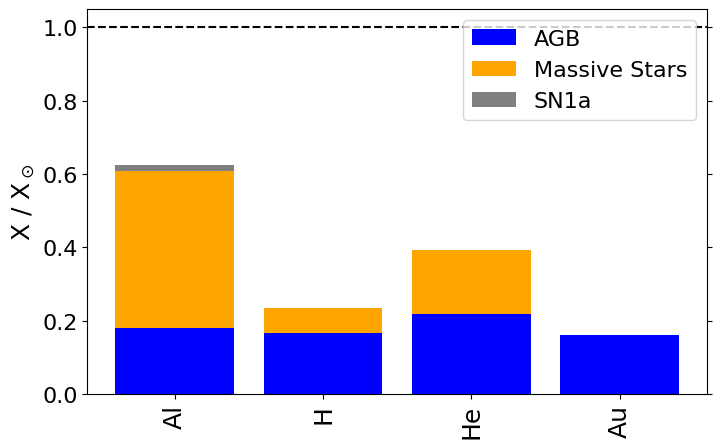

In [74]:
# \\\\\\\\\\ Modify below \\\\\\\\\\\\
# ====================================

# Select the isotopes you want to analyze
# It can also be a mix of isotopes and elements
# Example 1: species = ["C-12", "O-16", Fe-56"]
# Example 2: species = ["C-12", "C-13", "C", "Si-28"]
species = ["Al", "H", "He", "Au"]

# ====================================
# ////////// Modify above ////////////

# Set the figure size
fig = plt.figure(figsize=(8,5.0))
matplotlib.rcParams.update({'font.size': 16.0})

# Plot contributions
op_LC18.inner.mass_frac_plot(species=species, cycle=find_nearest(op_LC18.inner.history.metallicity, 0.014), yscale="linear")

# Increase size labels
plt.title("")
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18)
plt.ylabel("X / X$_\odot$", fontsize=18)

* If predictions **reach 1** on the y axis, you reproduced the Solar abundance for that isotope or element.
* If predictions are **above 1** on the y axis, you synthesized too much.
* If predictions are **below 1** on the y axis, you did not synthesize enough.